<a href="https://colab.research.google.com/github/tameralqadi/ML-Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data set from Kaggle (House Rent Prediction Dataset)
RandomForestRegressor

Final Results:
✅ Accuracy (R2 Score): 80.82%
📉 Mean Error (MAE) in Rupees: ₹7575.03
📉 Mean Error (MAE) in Dollars: $91.27


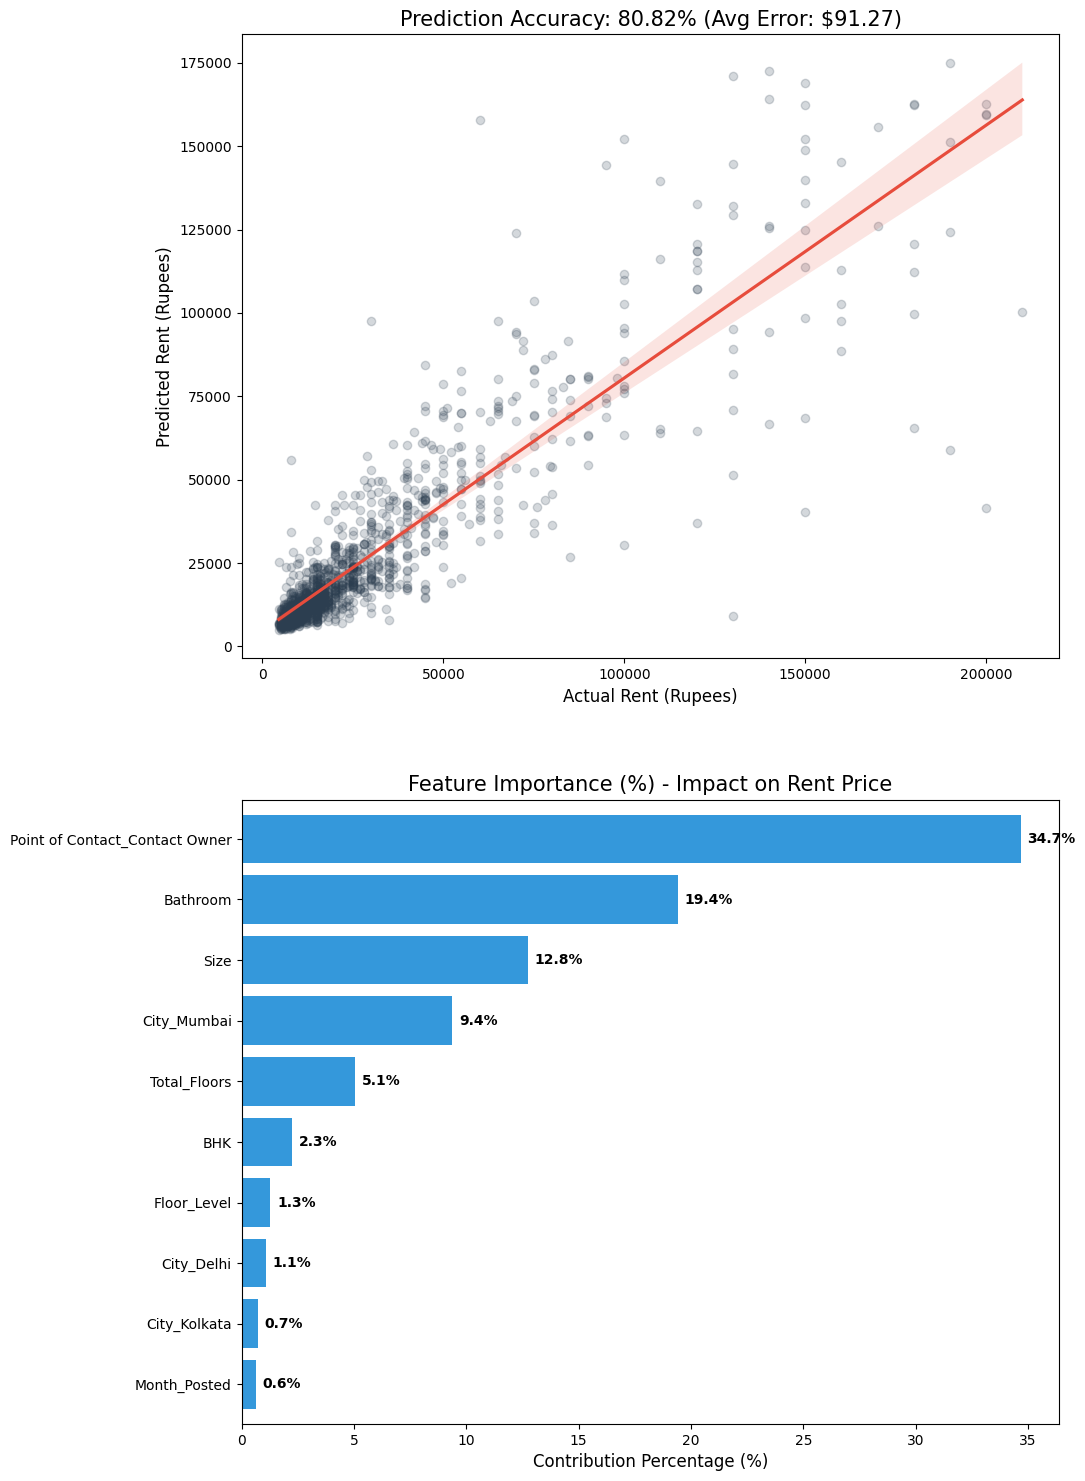

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

df = pd.read_csv('House_Rent_Dataset.csv')

df['Posted On'] = pd.to_datetime(df['Posted On'])
df['Month_Posted'] = df['Posted On'].dt.month

df['Locality_Score'] = df['Area Locality']

def split_floor(floor_str):
    parts = str(floor_str).split(' out of ')
    level = parts[0].strip()
    total = parts[1].strip() if len(parts) > 1 else "1"
    if 'Ground' in level: level_num = 0
    elif 'Basement' in level: level_num = -1
    else:
        try: level_num = int(level.split()[0])
        except: level_num = 0
    try: total_num = int(total)
    except: total_num = 1
    return level_num, total_num

df[['Floor_Level', 'Total_Floors']] = df['Floor'].apply(lambda x: pd.Series(split_floor(x)))

q_low, q_high = df['Rent'].quantile([0.01, 0.98])
df = df[(df['Rent'] > q_low) & (df['Rent'] < q_high)].copy()
df['Rent_Log'] = np.log1p(df['Rent'])

X = df.drop(['Rent', 'Rent_Log', 'Floor', 'Area Locality', 'Posted On'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['Rent_Log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
model = RandomForestRegressor(n_estimators=600, max_depth=30, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)


y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

#converge to dolar
r2_final = r2_score(y_test, y_pred_log) * 100
mae_rupees = mean_absolute_error(y_actual, y_pred)
mae_dollars = mae_rupees / 83  # سعر الصرف التقريبي

print("Final Results:")
print(f"✅ Accuracy (R2 Score): {r2_final:.2f}%")
print(f"📉 Mean Error (MAE) in Rupees: ₹{mae_rupees:.2f}")
print(f"📉 Mean Error (MAE) in Dollars: ${mae_dollars:.2f}")


plt.figure(figsize=(12, 16))

plt.subplot(2, 1, 1)
sns.regplot(x=y_actual, y=y_pred, scatter_kws={'alpha':0.2, 'color':'#2c3e50'}, line_kws={'color':'#e74c3c'})
plt.title(f'Prediction Accuracy: {r2_final:.2f}% (Avg Error: ${mae_dollars:.2f})', fontsize=15)
plt.xlabel('Actual Rent (Rupees)', fontsize=12)
plt.ylabel('Predicted Rent (Rupees)', fontsize=12)

plt.subplot(2, 1, 2)
importances = model.feature_importances_ * 100
feat_importances = pd.Series(importances, index=X.columns).sort_values().tail(10)

ax = feat_importances.plot(kind='barh', color='#3498db', width=0.8)
plt.title('Feature Importance (%) - Impact on Rent Price', fontsize=15)
plt.xlabel('Contribution Percentage (%)', fontsize=12)

for i, v in enumerate(feat_importances):
    ax.text(v + 0.3, i, f'{v:.1f}%', color='black', fontweight='bold', va='center')

plt.tight_layout(pad=5.0)
plt.show()